<a href="https://colab.research.google.com/github/saga743k/SPEECH-EMOTION-RECOGNITION/blob/main/1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import kagglehub
import librosa
import numpy as np

# Download dataset from Kaggle
path = kagglehub.dataset_download("ybsingh/indian-emotional-speech-corpora-iesc")
print("Path to dataset files:", path)

# Define dataset path
dataset_path = "/root/.cache/kagglehub/datasets/ybsingh/indian-emotional-speech-corpora-iesc/versions/1"

# Check if dataset path exists
if not os.path.exists(dataset_path):
    print("Error: Dataset path not found. Please check the download.")
    exit()

def is_valid_audio(file_path, min_duration=1.0):
    """Check if an audio file is valid based on minimum duration."""
    try:
        audio, sr = librosa.load(file_path, sr=None)
        return len(audio) / sr >= min_duration
    except Exception as e:  # Fixed syntax error here
        print(f"Error loading {file_path}: {e}")
        return False

# Get list of all .wav files (handling subdirectories)
audio_files = []
for root, _, files in os.walk(dataset_path):  # Recursively search all subfolders
    for f in files:
        if f.lower().endswith(".wav"):  # Improved case handling
            audio_files.append(os.path.join(root, f))  # Full path to file

# Validate files
valid_files = [f for f in audio_files if is_valid_audio(f)]

print(f"Valid files found: {len(valid_files)}")



100%|██████████| 131M/131M [00:01<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ybsingh/indian-emotional-speech-corpora-iesc/versions/1
Valid files found: 600


In [ ]:
import re

# Map first letters to emotions
emotion_map = {
    "A": "angry",
    "H": "happy",
    "S": "sad",
    "N": "neutral",
    "F": "fear",
    "D": "disgust",
    "U": "surprise"
}

# Function to extract audio features
def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=None)

        # Extract features
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr).T, axis=0)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio).T, axis=0)

        # Combine features
        features = np.hstack([mfccs, chroma, mel, contrast, zcr])
        return features
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

# Prepare data collection
data = []

# Iterate through files
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(".wav"):
            file_path = os.path.join(root, file)

            # Extract emotion label from filename
            match = re.search(r"[_-]?([AHSNFDU])[_-]?", file, re.IGNORECASE)
            emotion = emotion_map.get(match.group(1).upper(), "unknown") if match else "unknown"

            # Extract audio features
            features = extract_features(file_path)

            # Handle None, NaN, and incorrect length
            if features is not None and len(features) == 161 and not np.isnan(features).any():
                data.append([file, *features, emotion])
            else:
                print(f"Skipping {file} due to feature extraction issue or incorrect data length.")

# Create DataFrame
columns = ['filename'] + [f'mfcc_{i}' for i in range(13)] + \
          [f'chroma_{i}' for i in range(12)] + \
          [f'mel_{i}' for i in range(128)] + \
          [f'contrast_{i}' for i in range(7)] + ['zcr', 'emotion']

df = pd.DataFrame(data, columns=columns)

# Save to CSV
output_path = os.path.join(dataset_path, "features_extracted.csv")
df.to_csv(output_path, index=False)

print(f"Features extracted and saved to '{output_path}'")


Features extracted and saved to '/root/.cache/kagglehub/datasets/ybsingh/indian-emotional-speech-corpora-iesc/versions/1/features_extracted.csv'


In [ ]:
# Preview the first 5 rows of the CSV
print(df.head())

# Display basic info about the dataset
print("\nDataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values Summary:")
print(df.isnull().sum())


       filename      mfcc_0     mfcc_1     mfcc_2     mfcc_3    mfcc_4  \
0  S-10-8-2.wav -459.282654  72.344482  19.805935  16.113861 -9.464585   
1   S-3-8-1.wav -418.590546  76.953949   3.992547  13.788065  0.233321   
2   S-2-8-2.wav -441.440338  79.231415   6.379673   8.771214  5.681402   
3   S-9-8-1.wav -446.823334  74.595055   0.006960   5.111521  2.750653   
4   S-6-8-1.wav -420.155518  77.322510  -8.051875   6.525589  3.254393   

     mfcc_5     mfcc_6    mfcc_7     mfcc_8  ...   mel_127  contrast_0  \
0 -3.984922 -13.011098  5.983933  -5.672908  ...  0.000003   10.792435   
1 -1.059292 -11.583674 -1.364545 -11.736007  ...  0.000006   12.179473   
2  5.059304 -13.411305 -1.115655 -14.083760  ...  0.000005   11.198838   
3  1.373120 -14.367451 -3.792645 -11.357468  ...  0.000004   12.066068   
4 -0.810625 -11.840030 -2.584302 -16.866415  ...  0.000002   11.943645   

   contrast_1  contrast_2  contrast_3  contrast_4  contrast_5  contrast_6  \
0   16.434063   15.855481   16.14


Sample Rows for Each Emotion:

ANGRY Samples:
        filename emotion
80  A-10-8-1.wav   angry
81   A-8-8-1.wav   angry
82   A-5-8-1.wav   angry

HAPPY Samples:
       filename emotion
20  H-3-8-2.wav   happy
21  H-3-8-1.wav   happy
22  H-7-8-1.wav   happy

SAD Samples:
       filename emotion
0  S-10-8-2.wav     sad
1   S-3-8-1.wav     sad
2   S-2-8-2.wav     sad

NEUTRAL Samples:
       filename  emotion
40  N-1-8-2.wav  neutral
41  N-9-8-1.wav  neutral
42  N-1-8-1.wav  neutral

FEAR Samples:
        filename emotion
60   F-6-8-2.wav    fear
61   F-4-8-1.wav    fear
62  F-10-8-1.wav    fear

Emotion Distribution:
emotion
sad        120
happy      120
neutral    120
fear       120
angry      120
Name: count, dtype: int64


<ipython-input-5-821649a9cdf4>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='emotion', data=df, order=df['emotion'].value_counts().index, palette='Set2')


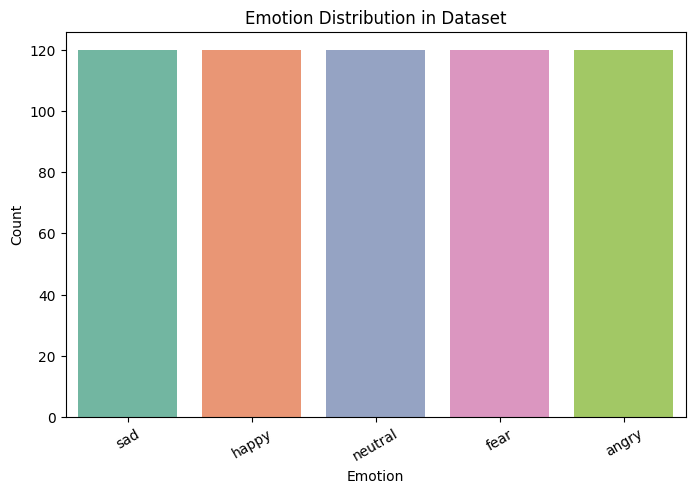

In [ ]:
# Display sample rows for each emotion
print("\nSample Rows for Each Emotion:")
for emotion in emotion_map.values():
    sample = df[df['emotion'] == emotion].head(3)  # Display 3 samples per emotion
    if not sample.empty:
        print(f"\n{emotion.upper()} Samples:")
        print(sample[['filename', 'emotion']])  # Show filename and emotion only

# Show distribution of emotions
print("\nEmotion Distribution:")
print(df['emotion'].value_counts())

# Visualize the distribution using a bar plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x='emotion', data=df, order=df['emotion'].value_counts().index, palette='Set2')
plt.title("Emotion Distribution in Dataset")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

# Extract feature columns (exclude 'filename' and 'emotion')
feature_columns = df.columns[1:-1]  # All columns except 'filename' and 'emotion'

# Standardization
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Save normalized data
normalized_output_path = os.path.join(dataset_path, "features_normalized.csv")
df.to_csv(normalized_output_path, index=False)

print(f"Normalized features saved to '{normalized_output_path}'")


Normalized features saved to '/root/.cache/kagglehub/datasets/ybsingh/indian-emotional-speech-corpora-iesc/versions/1/features_normalized.csv'


In [ ]:
from sklearn.model_selection import train_test_split

# Extract features and labels
X = df.drop(['filename', 'emotion'], axis=1).values
y = df['emotion'].values

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Training samples: 420
Validation samples: 90
Test samples: 90


In [ ]:
import pandas as pd

# Convert training, validation, and testing data to DataFrames
train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], -1))
train_df['emotion'] = y_train.argmax(axis=1) if y_train.ndim > 1 else y_train  # Convert if needed

val_df = pd.DataFrame(X_val.reshape(X_val.shape[0], -1))
val_df['emotion'] = y_val.argmax(axis=1) if y_val.ndim > 1 else y_val

test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))
test_df['emotion'] = y_test.argmax(axis=1) if y_test.ndim > 1 else y_test

# Print full datasets
print("\nTraining Data Samples:\n", train_df.head())  # Print first few rows
print("\nValidation Data Samples:\n", val_df.head())
print("\nTesting Data Samples:\n", test_df.head())

# Save full datasets to CSV files for reference
train_df.to_csv("training_data.csv", index=False)
val_df.to_csv("validation_data.csv", index=False)
test_df.to_csv("testing_data.csv", index=False)

print("\nTraining, Validation, and Testing datasets saved as CSV files.")



Training Data Samples:
           0         1         2         3         4         5         6  \
0  1.483651 -0.702664  0.178423 -0.840547 -1.480634 -0.750581 -1.689492   
1 -1.270411  0.060102  2.214867  1.763985 -0.177006 -0.199039  1.213200   
2  1.323607  0.009291 -0.831630  0.522032  0.375059 -0.952780 -1.036325   
3  0.101718 -1.093250 -1.086541 -0.350205  0.295380 -0.345365  0.265521   
4  1.373371  1.049777  0.050843 -0.713965  0.612296  1.174373  0.350389   

          7         8         9  ...       152       153       154       155  \
0 -1.079024 -0.430629 -1.394000  ...  0.121160  0.254321  0.081034  0.351574   
1 -0.193923 -0.136997  1.605834  ... -0.164288 -0.298496 -1.259416 -0.624605   
2 -1.409383 -1.954462 -1.971381  ... -0.146587 -1.107743  2.210325  1.404581   
3 -0.188304 -1.359300  0.266202  ... -0.153672 -0.974809 -0.317740 -0.407156   
4  0.950838  1.015500  0.371161  ... -0.159851 -1.222034 -1.223921 -0.994524   

        156       157       158       159  

In [ ]:
import pandas as pd

# Load the original dataset DataFrame that includes filenames
original_df = df  # Assuming df contains 'filename' and 'emotion'

# Extract filenames for training, validation, and testing splits
train_filenames = original_df.iloc[:len(X_train)]['filename'].values
val_filenames = original_df.iloc[len(X_train):len(X_train) + len(X_val)]['filename'].values
test_filenames = original_df.iloc[len(X_train) + len(X_val):]['filename'].values

# Create DataFrames with actual filenames
train_df = pd.DataFrame({'filename': train_filenames, 'emotion': y_train.argmax(axis=1) if y_train.ndim > 1 else y_train})
val_df = pd.DataFrame({'filename': val_filenames, 'emotion': y_val.argmax(axis=1) if y_val.ndim > 1 else y_val})
test_df = pd.DataFrame({'filename': test_filenames, 'emotion': y_test.argmax(axis=1) if y_test.ndim > 1 else y_test})

# Print a preview of the actual filenames with their labels
print("\nTraining Data Samples:\n", train_df.head())  # Show first 5 rows
print("\nValidation Data Samples:\n", val_df.head())
print("\nTesting Data Samples:\n", test_df.head())

# Save to CSV files for reference
train_df.to_csv("training_filenames.csv", index=False)
val_df.to_csv("validation_filenames.csv", index=False)
test_df.to_csv("testing_filenames.csv", index=False)

print("\nTraining, Validation, and Testing filenames saved as CSV files.")



Training Data Samples:
        filename  emotion
0  S-10-8-2.wav    angry
1   S-3-8-1.wav  neutral
2   S-2-8-2.wav      sad
3   S-9-8-1.wav    angry
4   S-6-8-1.wav     fear

Validation Data Samples:
       filename  emotion
0  N-5-2-2.wav    angry
1  N-4-2-2.wav     fear
2  N-3-2-2.wav  neutral
3  N-1-2-1.wav    happy
4  N-2-2-1.wav     fear

Testing Data Samples:
       filename emotion
0  S-1-7-2.wav   angry
1  S-6-7-2.wav   angry
2  S-5-7-2.wav    fear
3  S-7-7-1.wav   happy
4  S-8-7-1.wav   happy

Training, Validation, and Testing filenames saved as CSV files.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Ensure 'filename' is included in df before splitting
filenames = df['filename'].values
emotions = df['emotion'].values

# Extract features
X = df.drop(['filename', 'emotion'], axis=1).values
y = emotions  # Keep as categorical labels

# Split data (ensure filenames and labels are split together)
X_train, X_temp, y_train, y_temp, train_filenames, temp_filenames = train_test_split(
    X, y, filenames, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test, val_filenames, test_filenames = train_test_split(
    X_temp, y_temp, temp_filenames, test_size=0.5, stratify=y_temp, random_state=42
)

# Create DataFrames with actual filenames
train_df = pd.DataFrame({'filename': train_filenames, 'emotion': y_train})
val_df = pd.DataFrame({'filename': val_filenames, 'emotion': y_val})
test_df = pd.DataFrame({'filename': test_filenames, 'emotion': y_test})

# Print a preview of actual filenames with their labels
print("\nTraining Data Samples:\n", train_df.head())
print("\nValidation Data Samples:\n", val_df.head())
print("\nTesting Data Samples:\n", test_df.head())

# Save to CSV files for reference
train_df.to_csv("training_filenames.csv", index=False)
val_df.to_csv("validation_filenames.csv", index=False)
test_df.to_csv("testing_filenames.csv", index=False)

print("\nTraining, Validation, and Testing filenames saved as CSV files.")



Training Data Samples:
        filename  emotion
0   A-1-4-1.wav    angry
1   N-7-6-2.wav  neutral
2  S-10-5-2.wav      sad
3   A-9-5-1.wav    angry
4   F-6-7-1.wav     fear

Validation Data Samples:
       filename  emotion
0  A-1-7-2.wav    angry
1  F-4-6-1.wav     fear
2  N-4-1-1.wav  neutral
3  H-4-4-2.wav    happy
4  F-7-6-1.wav     fear

Testing Data Samples:
       filename emotion
0  A-8-5-1.wav   angry
1  A-5-3-2.wav   angry
2  F-9-7-2.wav    fear
3  H-2-8-2.wav   happy
4  H-1-3-2.wav   happy

Training, Validation, and Testing filenames saved as CSV files.


In [ ]:
# Reshape data for 1D CNN (samples, features, 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Define CNN model
def build_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # Input Layer (Reshape for CNN compatibility)
    model.add(layers.Reshape((input_shape[0], input_shape[1], 1), input_shape=input_shape))

    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    # Flatten the data for Dense layers
    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output Layer (Softmax for multi-class classification)
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Example usage
input_shape = (161, 1)  # Assuming extracted features are reshaped as (161, 1)
num_classes = 7         # Number of emotion labels

cnn_model = build_cnn_model(input_shape, num_classes)
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 161, 1, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 161, 1, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 161, 1, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 0, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 0, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 0, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 0, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 0, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 0, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 0, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 0, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 0, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 0)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,599 (369.53 KB)

 Trainable params: 94,151 (367.78 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Extract features and labels
X = df.drop(['filename', 'emotion'], axis=1).values
y = df['emotion'].values

# Reshape data for CNN (Add channel dimension)
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels (Convert string labels to integers)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert to categorical for multi-class classification
y_categorical = to_categorical(y_encoded)

print(f"Reshaped Data Shape: {X_reshaped.shape}")
print(f"Encoded Labels Shape: {y_categorical.shape}")


Reshaped Data Shape: (600, 161, 1)
Encoded Labels Shape: (600, 5)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Extract features and labels
X = df.drop(['filename', 'emotion'], axis=1).values
y = df['emotion'].values

# Reshape data for CNN (Add channel dimension)
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)  # For Conv1D, this is correct

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print(f"Reshaped Data Shape: {X_reshaped.shape}")

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X_reshaped, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42
)

# Define the CNN model
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(32, 3, activation='relu', padding='same', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),  # Prevents overfitting
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize model
cnn_model = build_cnn_model(input_shape=(X_train.shape[1], 1), num_classes=y_categorical.shape[1])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Ensure model directory exists
if not os.path.exists('models/'):
    os.makedirs('models/')

# Save the model
cnn_model.save('models/emotion_detection_cnn.h5')
print("Model training complete and saved as 'models/emotion_detection_cnn.h5'")


Reshaped Data Shape: (600, 161, 1)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3293 - loss: 1.5374 - val_accuracy: 0.5333 - val_loss: 1.2390 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4820 - loss: 1.2597 - val_accuracy: 0.6167 - val_loss: 1.0313 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5909 - loss: 1.0544 - val_accuracy: 0.6417 - val_loss: 0.9097 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6967 - loss: 0.8216 - val_accuracy: 0.8167 - val_loss: 0.7089 - learning_rate: 0.0010
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8217 - loss: 0.6715 - val_accuracy: 0.8167 - val_loss: 0.6000 - learning_rate: 0.0010
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8395 - loss: 0.6029 - val_accuracy: 0.8000 - val_loss: 0.5569 - learning_rate: 0.0010
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8511 - loss: 0.4883 - val_accuracy: 0.83

Model training complete and saved as 'models/emotion_detection_cnn.h5'


In [ ]:
# Evaluate the model
val_loss, val_accuracy = cnn_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8681 - loss: 0.3166
Validation Accuracy: 0.8500
Validation Loss: 0.3785


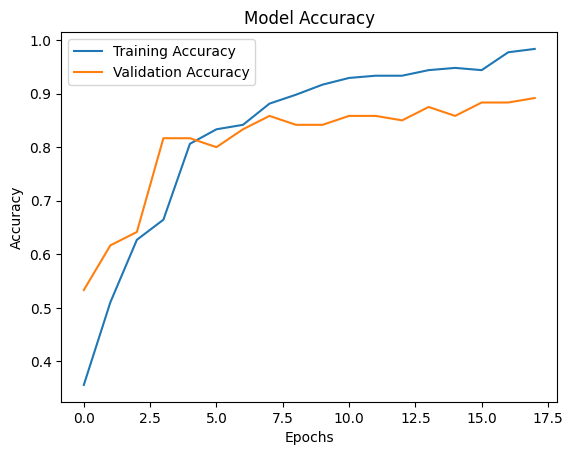

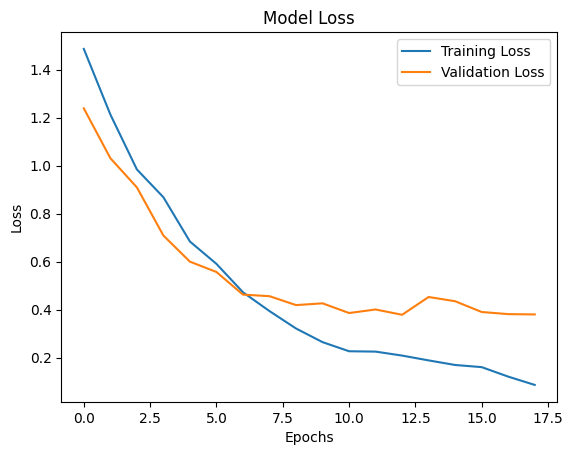

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


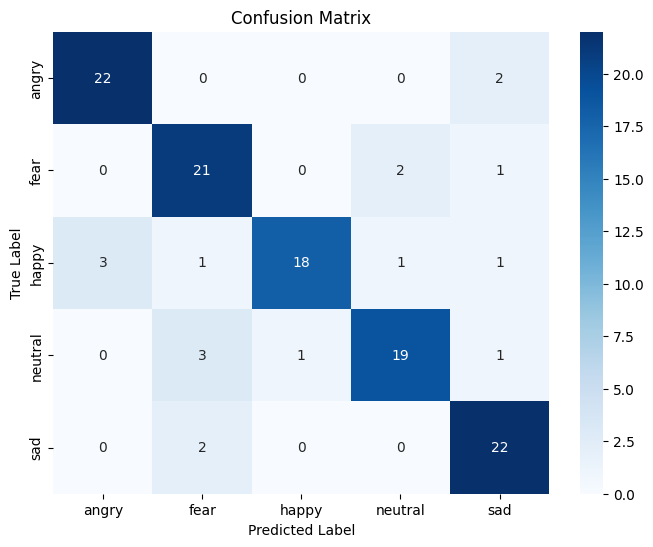

              precision    recall  f1-score   support

       angry       0.88      0.92      0.90        24
        fear       0.78      0.88      0.82        24
       happy       0.95      0.75      0.84        24
     neutral       0.86      0.79      0.83        24
         sad       0.81      0.92      0.86        24

    accuracy                           0.85       120
   macro avg       0.86      0.85      0.85       120
weighted avg       0.86      0.85      0.85       120



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Predict on validation data
y_pred = cnn_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Assuming you already have y_test as integer labels
# If not, and it's still in string format:
y_test_encoded = label_encoder.transform(y_test)  # Encode string to int

# One-hot encode
y_test_categorical = to_categorical(y_test_encoded)
# Evaluate on test data
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test_categorical, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8575 - loss: 0.4038
Test Accuracy: 0.86
Test Loss: 0.40


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

       angry       0.89      0.94      0.92        18
        fear       0.79      0.83      0.81        18
       happy       0.93      0.78      0.85        18
     neutral       0.82      0.78      0.80        18
         sad       0.85      0.94      0.89        18

    accuracy                           0.86        90
   macro avg       0.86      0.86      0.85        90
weighted avg       0.86      0.86      0.85        90



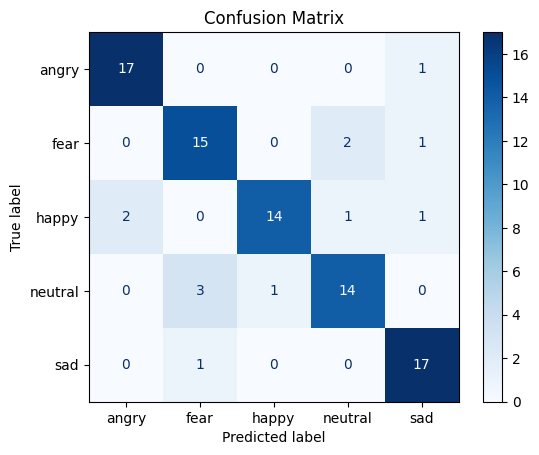

In [ ]:
# Step 1: Encode test labels (if not done already)
y_test_encoded = label_encoder.transform(y_test)  # convert string labels to integers
y_test_categorical = to_categorical(y_test_encoded)  # one-hot encode

# Step 2: Predict
y_pred_probs = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Step 3: Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


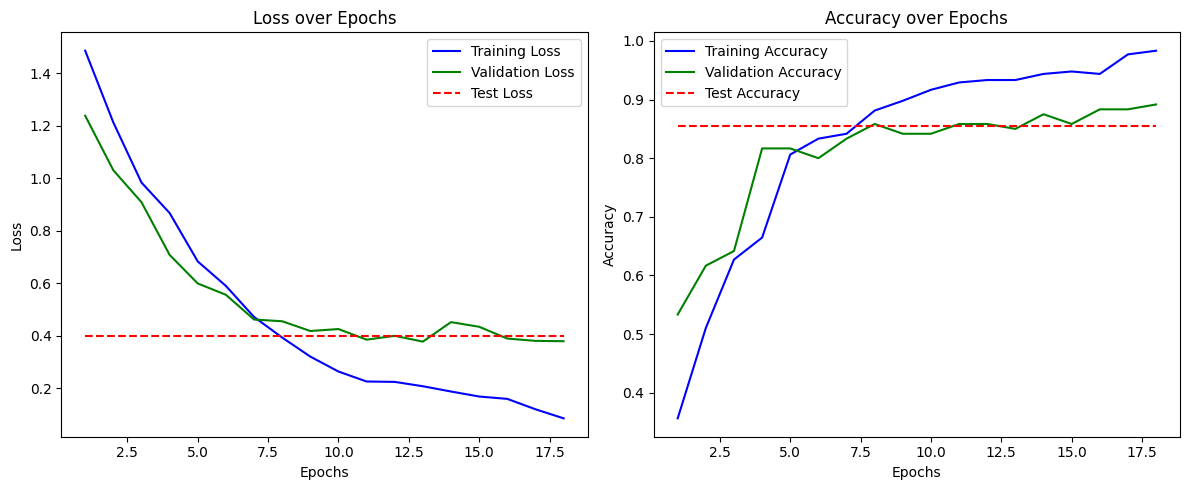

In [ ]:
import matplotlib.pyplot as plt

# Training metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.hlines(test_loss, xmin=1, xmax=len(train_loss), colors='r', linestyles='--', label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')
plt.hlines(test_accuracy, xmin=1, xmax=len(train_acc), colors='r', linestyles='--', label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Classification report dictionary
report_dict = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Add test loss & accuracy
df_report.loc["Test Summary"] = [test_accuracy, test_loss, None, None]

# Save to Excel
df_report.to_excel("testing_report.xlsx")
print("Testing report saved as 'testing_report.xlsx'")


Testing report saved as 'testing_report.xlsx'


In [ ]:
from google.colab import files
files.download("testing_report.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!git clone https://github.com/zohaibahmad01/RAVDESS-Speech-Only-Small-Subset.git


Cloning into 'RAVDESS-Speech-Only-Small-Subset'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
# STEP 1: Clone the small RAVDESS subset (24 files, ~15MB)
!git clone https://github.com/zohaibahmad01/RAVDESS-Speech-Only-Small-Subset.git


Cloning into 'RAVDESS-Speech-Only-Small-Subset'...
fatal: could not read Username for 'https://github.com': No such device or address
